Step 1: Imports

In [88]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


Step 2: Prepare Data Transforms

In [89]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

Step 3: Creating datasets

In [90]:
train = datasets.MNIST('./data', train = True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform=test_transforms)

Step 4: Creating data loaders

In [91]:
SEED = 1

cuda = torch.cuda.is_available()
print("Is cuda available? ", cuda)

#set the seed of the random number generator to a fixed value
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


Is cuda available?  True


Step 5: Data Stats

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


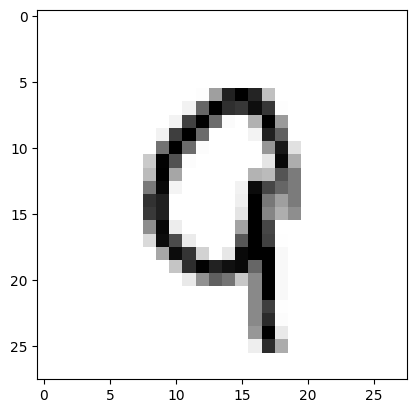

In [93]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


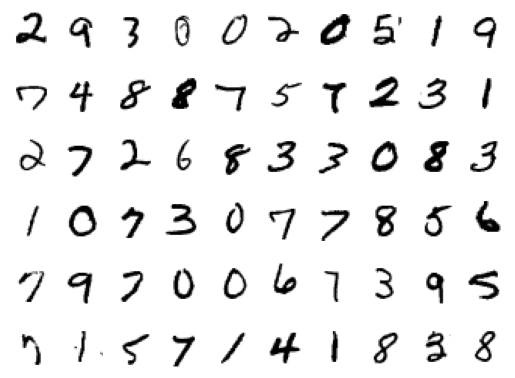

In [94]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Step 6: Model

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 10, RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 8, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 6, RF = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 4, RF = 22
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 2, RF = 26
        # OUTPUT BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 2, RF = 26

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Step 7: Model Parameters

In [96]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,080
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 10, 12, 12]             120
            Conv2d-9           [-1, 12, 10, 10]           1,080
      BatchNorm2d-10           [-1, 12, 10, 10]              24
             ReLU-11           [-1, 12, 10, 10]               0
           Conv2d-12             [-1, 12, 8, 8]           1,296

Step 8: Training and Testing

In [97]:
from tqdm import tqdm

train_acc = []
test_acc = []
train_losses = []
test_losses = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim = 1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


Step 9: Train and Test calls

In [98]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04088675603270531 Batch_id=468 Accuracy=90.16: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]



Test set: Average loss: 0.0755, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.042133230715990067 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0486, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.03610541298985481 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]



Test set: Average loss: 0.0467, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.046594008803367615 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 22.33it/s]



Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.006642711814492941 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]



Test set: Average loss: 0.0291, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.05945810303092003 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 0.0330, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.02286490797996521 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]



Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.013860316015779972 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]



Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.005078818649053574 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]



Test set: Average loss: 0.0294, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.07308229804039001 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.045115530490875244 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0260, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.00932923424988985 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]



Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.049141738563776016 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.006830950733274221 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0253, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.00701192207634449 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]



Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.022679254412651062 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]



Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)

